## Building model
### Libraries

In [22]:
# Supress warnings
import warnings
warnings.filterwarnings('ignore')

import os
import matplotlib.pyplot as plt
#import pandas as pd
import seaborn as sns
import numpy as np
import cv2
from PIL import Image
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Input
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score


### Loading datasets

In [2]:
actions = np.array(['adios', 'amor', 'animal',
                    'bienvenida', 'gracias', 'hola', 
                    'hombre', 'internet', 'mujer',
                    'nino_na', 'objeto', 'persona',
                    'radio', 'television', 'tristeza'])

In [3]:
data_folder='dataset/size_0_3'

X_train=np.load(os.path.join(data_folder, 'X_train.npy'))
X_val=np.load(os.path.join(data_folder, 'X_test.npy'))
y_train=np.load(os.path.join(data_folder, 'y_train.npy'))
y_val=np.load(os.path.join(data_folder, 'y_test.npy'))

In [4]:
X_train.shape

(315, 30, 1662)

In [5]:
y_train.shape

(315, 15)

In [12]:
# Reformatear los datos para tener tres canales
X_train_reshaped = X_train.reshape(-1, 1662, 30)
X_train_rgb = np.repeat(X_train_reshaped[..., np.newaxis], 3, axis=-1)

X_val_reshaped = X_val.reshape(-1, 1662, 30)
X_val_rgb = np.repeat(X_val_reshaped[..., np.newaxis], 3, axis=-1)

In [14]:
X_train_rgb.shape

(315, 1662, 30, 3)

In [16]:
# Definir la nueva forma deseada
new_shape = (32, 32)

# Crear una lista para almacenar los registros transformados
X_train_transformed = []

# Iterar sobre cada registro en X_train_rgb
for sample in X_train_rgb:
    # Redimensionar la imagen a la nueva forma
    resized_image = cv2.resize(sample, new_shape[:2], interpolation=cv2.INTER_AREA)
    
    # Rellenar la imagen si es necesario
    if resized_image.shape[0] < new_shape[0] or resized_image.shape[1] < new_shape[1]:
        top_pad = (new_shape[0] - resized_image.shape[0]) // 2
        bottom_pad = new_shape[0] - resized_image.shape[0] - top_pad
        left_pad = (new_shape[1] - resized_image.shape[1]) // 2
        right_pad = new_shape[1] - resized_image.shape[1] - left_pad
        resized_image = cv2.copyMakeBorder(resized_image, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=0)
    
    # Agregar la imagen transformada a la lista
    X_train_transformed.append(resized_image)

# Convertir la lista a un array numpy
X_train_transformed = np.array(X_train_transformed)

# Verificar la forma del nuevo array
print("Nueva forma de X_train_transformed:", X_train_transformed.shape)

Nueva forma de X_train_transformed: (315, 32, 32, 3)


In [17]:
# Definir la nueva forma deseada
new_shape = (32, 32)

# Crear una lista para almacenar los registros transformados
X_val_transformed = []

# Iterar sobre cada registro en X_val_rgb
for sample in X_val_rgb:
    # Redimensionar la imagen a la nueva forma
    resized_image = cv2.resize(sample, new_shape[:2], interpolation=cv2.INTER_AREA)
    
    # Rellenar la imagen si es necesario
    if resized_image.shape[0] < new_shape[0] or resized_image.shape[1] < new_shape[1]:
        top_pad = (new_shape[0] - resized_image.shape[0]) // 2
        bottom_pad = new_shape[0] - resized_image.shape[0] - top_pad
        left_pad = (new_shape[1] - resized_image.shape[1]) // 2
        right_pad = new_shape[1] - resized_image.shape[1] - left_pad
        resized_image = cv2.copyMakeBorder(resized_image, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=0)
    
    # Agregar la imagen transformada a la lista
    X_val_transformed.append(resized_image)

# Convertir la lista a un array numpy
X_val_transformed = np.array(X_val_transformed)

# Verificar la forma del nuevo array
print("Nueva forma de X_val_transformed:", X_val_transformed.shape)

Nueva forma de X_val_transformed: (135, 32, 32, 3)


### Build and Train LSTM Neural Network

In [4]:
log_dir=os.path.join('Logs/log_pt10_noes')
tb_callback=TensorBoard(log_dir=log_dir)

In [18]:
# Definir el modelo VGG16 preentrenado con la entrada reformateada
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [31]:
# Congelar las capas del modelo base (VGG16)
for layer in base_model.layers:
    layer.trainable = False

In [19]:
# Crear un nuevo modelo Sequential
model = Sequential()

In [20]:
# Añadir el modelo base VGG16
model.add(base_model)

In [21]:
# Agregar capas adicionales
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(15, activation='softmax'))  # Salida con 15 clases (predicciones categóricas)

In [26]:
# Compilar el modelo
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [27]:
# Entrenar el modelo
history = model.fit(X_train_transformed, y_train, validation_data=(X_val_transformed, y_val), epochs=1000, batch_size=32)

Epoch 1/1000
10/10 [==============================] - 8s 543ms/step - loss: 2.8216 - categorical_accuracy: 0.0762 - val_loss: 2.8001 - val_categorical_accuracy: 0.0296
Epoch 2/1000
10/10 [==============================] - 5s 520ms/step - loss: 2.7673 - categorical_accuracy: 0.0762 - val_loss: 2.7359 - val_categorical_accuracy: 0.0296
Epoch 3/1000
10/10 [==============================] - 5s 519ms/step - loss: 2.7319 - categorical_accuracy: 0.0667 - val_loss: 2.7486 - val_categorical_accuracy: 0.0444
Epoch 4/1000
10/10 [==============================] - 5s 535ms/step - loss: 2.7203 - categorical_accuracy: 0.0730 - val_loss: 2.7612 - val_categorical_accuracy: 0.0296
Epoch 5/1000
10/10 [==============================] - 5s 526ms/step - loss: 2.7252 - categorical_accuracy: 0.0857 - val_loss: 2.7632 - val_categorical_accuracy: 0.0667
Epoch 6/1000
10/10 [==============================] - 5s 533ms/step - loss: 2.7083 - categorical_accuracy: 0.0762 - val_loss: 2.6137 - val_categorical_accuracy:

In [9]:
%load_ext tensorboard
%tensorboard --logdir=./Logs

Reusing TensorBoard on port 6006 (pid 21412), started 8:04:15 ago. (Use '!kill 21412' to kill it.)

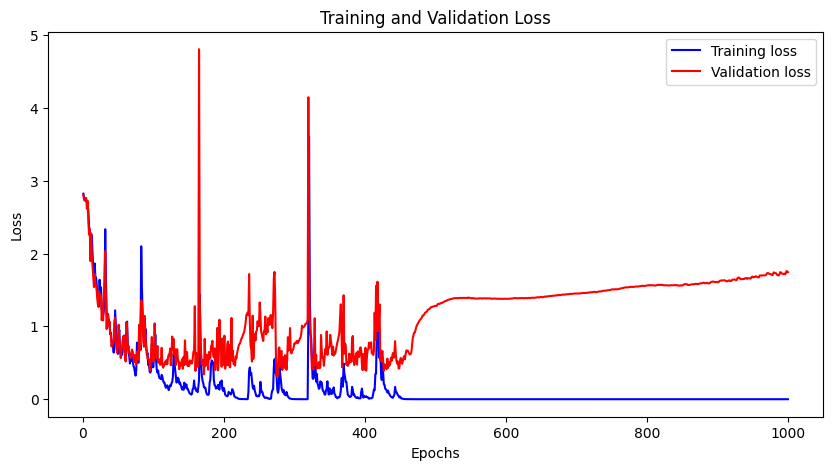

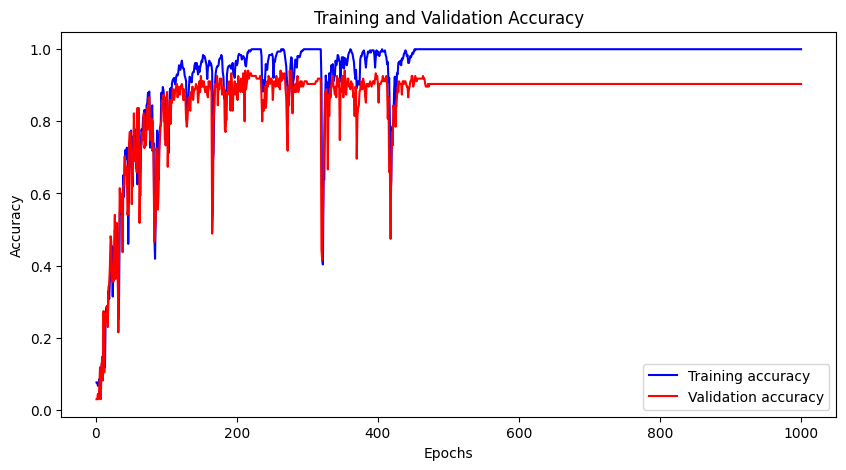

In [28]:
# Obtener las métricas de pérdida y precisión
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy=history.history['categorical_accuracy']
val_accuracy=history.history['val_categorical_accuracy']
epochs = range(1, len(train_loss) + 1)

# Gráfica de pérdida
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Gráfica de precisión
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Make Predictions

In [30]:
res=model.predict(X_val_transformed)

5/5 [==============================] - 0s 56ms/step


In [31]:
actions[np.argmax(res[0])]

'animal'

In [32]:
actions[np.argmax(y_val[0])]

'animal'

## Save Weights
### Saving model

In [53]:
# Check if the directory 'models' already exists
if not os.path.exists("models"):
    os.makedirs("models")

In [54]:
# Saving the model
model.save("models/sl_model_ver1.h5")

### Loading model

In [15]:
# Path to the model file
model_path="models/sl_model_ver1.h5"

In [16]:
# Load the model
model=load_model(model_path)

In [17]:
# Check the structure model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 15)                495       
                                                                 
Total params: 597071 (2.28 MB)
Trainable params: 597071 

In [18]:
model.load_weights(model_path)

### Evaluation using Confusion Matrix and Accuracy

In [33]:
ypred=model.predict(X_val_transformed)

5/5 [==============================] - 0s 51ms/step


In [34]:
ytrue=np.argmax(y_val, axis=1)
ypred=np.argmax(ypred, axis=1)

In [35]:
# Calcular la matriz de confusión multilabel
confusion_matrix=multilabel_confusion_matrix(ytrue, ypred)
confusion_matrix

array([[[127,   1],
        [  2,   5]],

       [[121,   0],
        [  0,  14]],

       [[123,   0],
        [  1,  11]],

       [[129,   0],
        [  0,   6]],

       [[127,   2],
        [  0,   6]],

       [[126,   0],
        [  2,   7]],

       [[120,   3],
        [  3,   9]],

       [[124,   0],
        [  0,  11]],

       [[125,   0],
        [  2,   8]],

       [[124,   1],
        [  0,  10]],

       [[130,   1],
        [  0,   4]],

       [[123,   2],
        [  0,  10]],

       [[130,   0],
        [  0,   5]],

       [[127,   0],
        [  0,   8]],

       [[121,   3],
        [  3,   8]]], dtype=int64)

In [36]:
len(confusion_matrix)

15

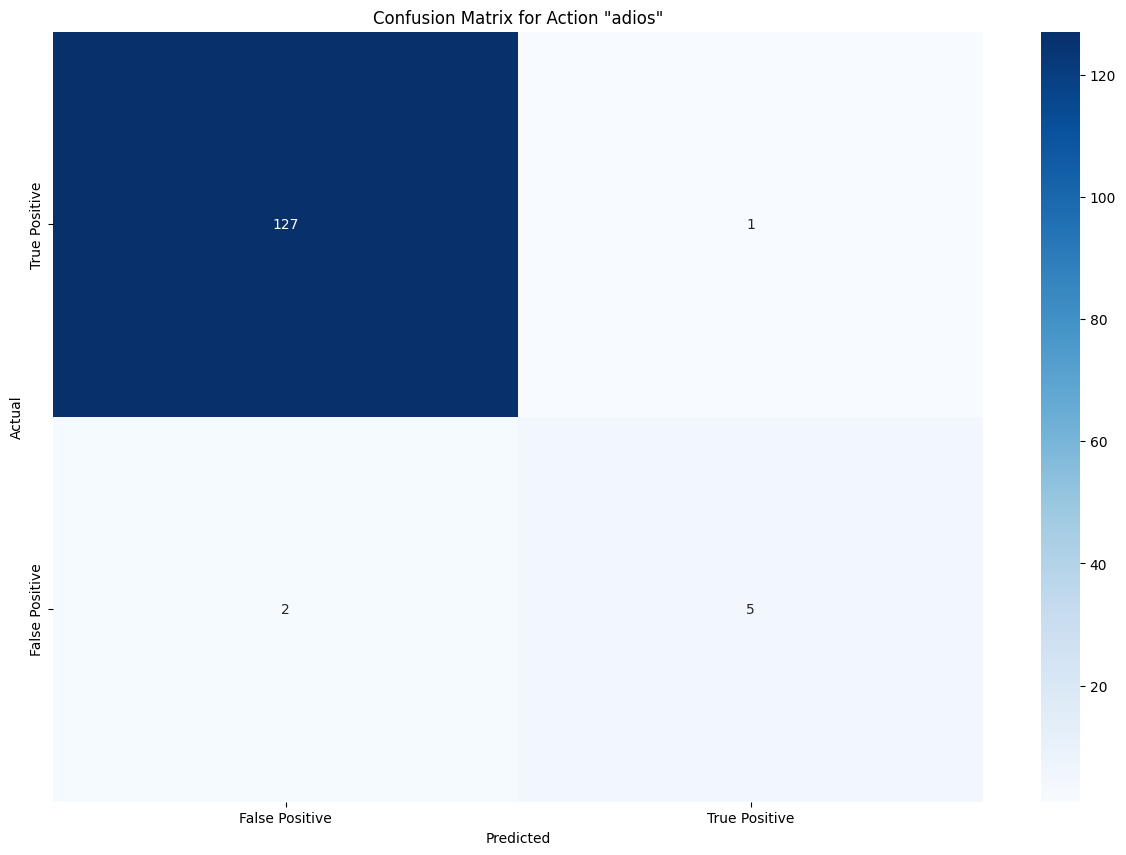

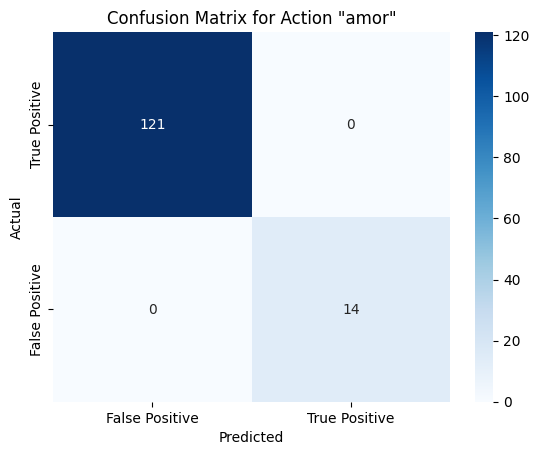

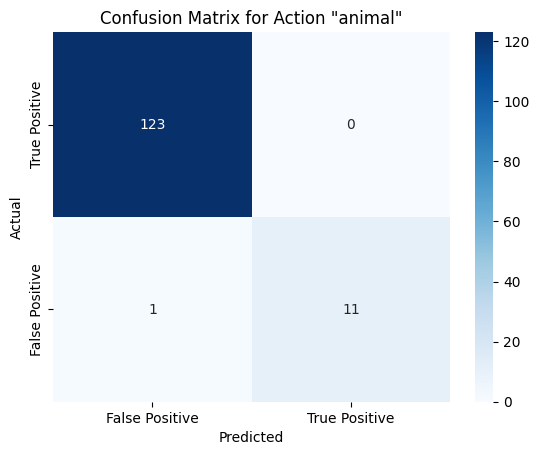

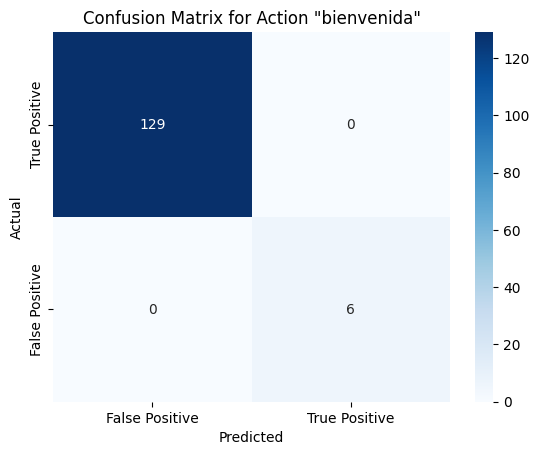

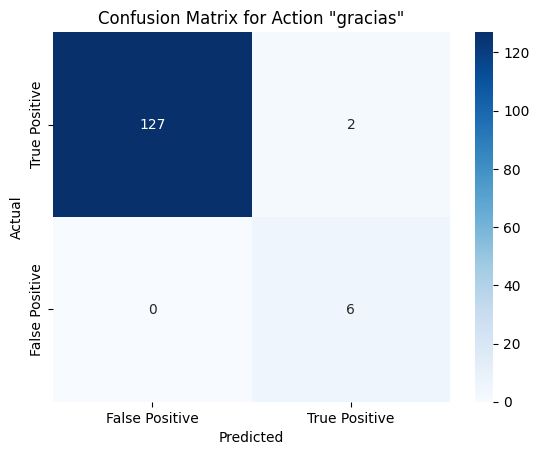

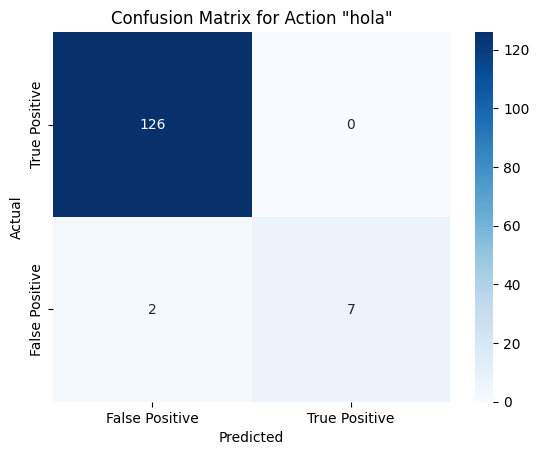

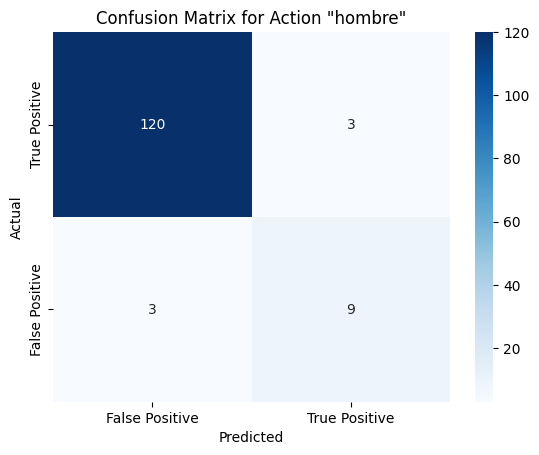

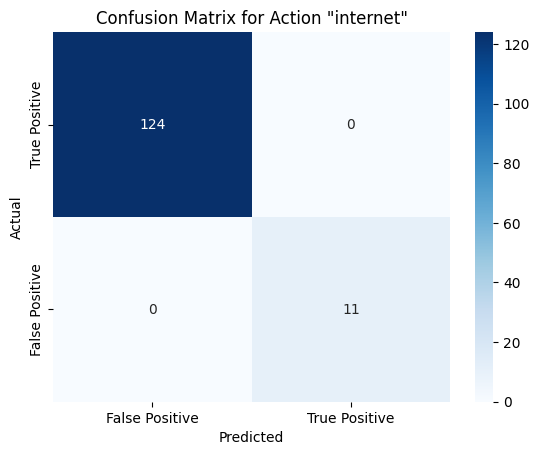

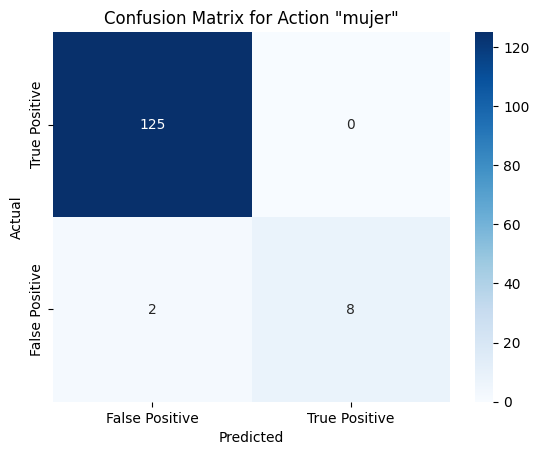

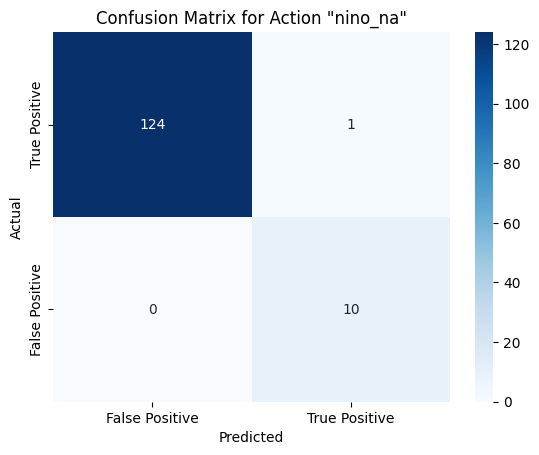

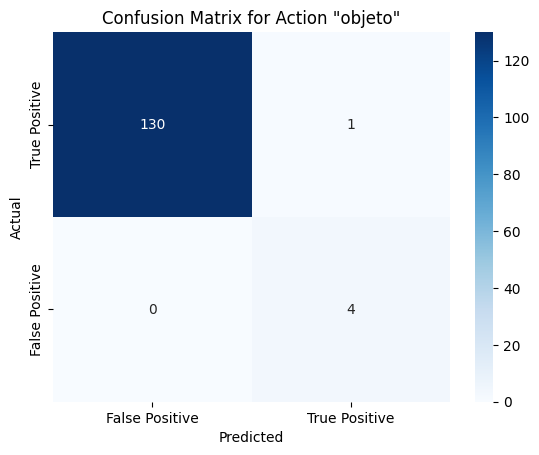

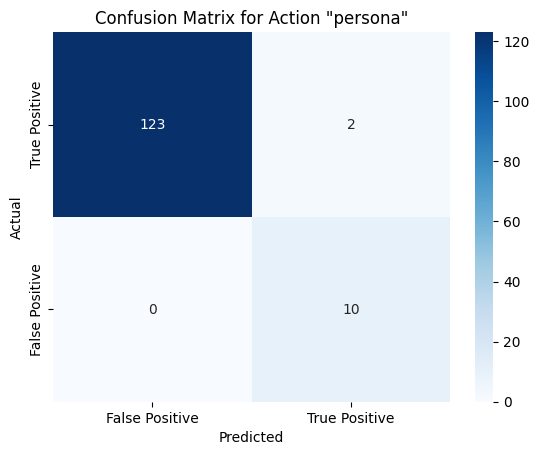

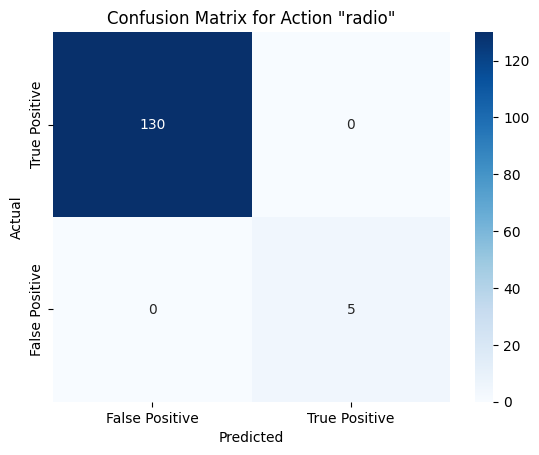

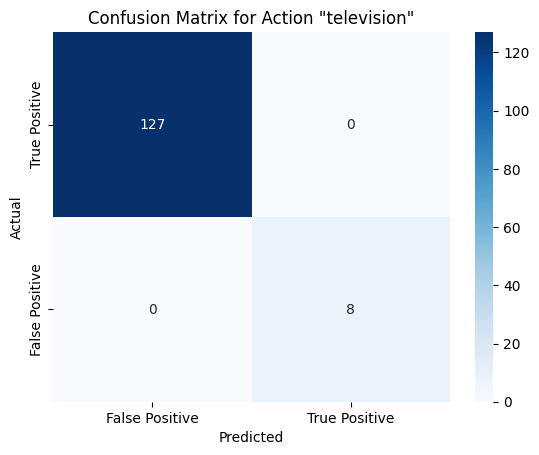

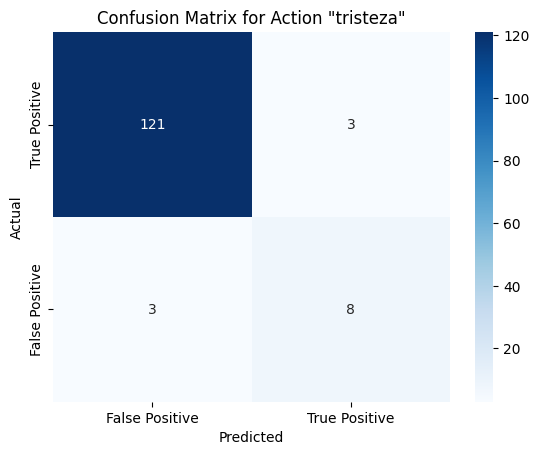

In [37]:
# Visualización usando Seaborn
plt.figure(figsize=(15, 10))
for i in range(len(confusion_matrix)):
    # Verificar si hay alguna predicción para esta acción
    if np.any(np.array([ytrue == i, ypred == i]).T):
        sns.heatmap(confusion_matrix[i], annot=True, fmt='.0f', cmap='Blues', 
                    xticklabels=['False Positive', 'True Positive'],
                    yticklabels=['True Positive', 'False Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix for Action "{actions[i]}"')
        plt.show()

In [39]:
ytrue = np.argmax(y_val, axis=1).tolist()
ypred = model.predict(X_val_transformed)
ypred = np.argmax(ypred, axis=1).tolist()
accuracy_score(ytrue, ypred)

5/5 [==============================] - 0s 56ms/step


0.9037037037037037